In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
df=pd.read_csv("train.csv")

In [3]:
df

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1
...,...,...,...,...,...,...,...,...
409,409,1.011,5.21,527,21.4,75,1.53,0
410,410,1.024,5.53,577,19.7,224,0.77,0
411,411,1.018,6.28,455,22.2,270,7.68,1
412,412,1.008,7.12,325,12.6,75,1.03,1


In [4]:
#z score normalization
cols=['gravity','ph','osmo','cond','urea','calc']
for i in cols:
    df[i]=((df[i]-np.mean(df[i]))/np.std(df[i]))

In [5]:
X=df.drop(['id','target'],axis=1)
Y=df['target']

In [135]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,train_size=0.70,shuffle=True)

In [136]:
from keras.layers import Dense,Flatten,BatchNormalization,Input,Dropout
from keras.models import Model

In [137]:


def scheduler(epochs,lr):
    if(epochs<10):
        return lr
    else:
        return lr*tf.math.exp(-0.01*epochs)

In [138]:
#Neural network architecture
def model_creation():
    input_layer=Input((6,))

    #create the dense layers
    dense0=Dense(32,activation='tanh',kernel_initializer='glorot_uniform')(input_layer)
    dense=BatchNormalization()(dense0)

    dense1=Dense(64,activation='tanh',kernel_initializer='glorot_uniform')(dense0)
    dense1=BatchNormalization()(dense1)

    dense2=Dense(128,activation='tanh',kernel_initializer='glorot_uniform')(dense1)
    dense2=BatchNormalization()(dense2)

    dense3=Dense(256,activation='tanh',kernel_initializer='glorot_uniform')(dense2)
    dense3=BatchNormalization()(dense3)
    dense3=Dropout(rate=0.2)(dense3)
    
    dense4=Dense(128,activation='tanh',kernel_initializer='glorot_uniform')(dense3)
    dense4=BatchNormalization()(dense4)

    dense5=Dense(64,activation='tanh',kernel_initializer='glorot_uniform')(dense4)
    dense5=BatchNormalization()(dense5)

    dense6=Dense(32,activation='relu',kernel_initializer='glorot_uniform')(dense5)
    dense6=BatchNormalization()(dense6)

    output=Dense(1,activation='sigmoid',kernel_initializer='glorot_uniform')(dense5)

    model=Model(inputs=input_layer,outputs=output)

    return model

In [139]:
model=model_creation()

In [140]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_40 (Dense)            (None, 32)                224       
                                                                 
 dense_41 (Dense)            (None, 64)                2112      
                                                                 
 batch_normalization_36 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_42 (Dense)            (None, 128)               8320      
                                                                 
 batch_normalization_37 (Bat  (None, 128)              512       
 chNormalization)                                          

In [141]:
#Set the hyperparameters for model
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy,MeanAbsoluteError,RootMeanSquaredError,MeanSquaredError
from keras.losses import BinaryCrossentropy

model.compile(optimizer=Adam(learning_rate=0.001),loss=BinaryCrossentropy(),metrics=[BinaryAccuracy(),MeanAbsoluteError(),MeanSquaredError(),RootMeanSquaredError()])


In [142]:
#Write a learning rate scheduler
scheduler_callback=tf.keras.callbacks.LearningRateScheduler(scheduler)

In [143]:
learning=model.fit(x_train,y_train,epochs=350,batch_size=16,verbose=1,validation_data=(x_test,y_test),callbacks=[scheduler_callback])

Epoch 1/350
19/19 [==============================] - 4s 39ms/step - loss: 0.7159 - binary_accuracy: 0.6678 - mean_absolute_error: 0.3959 - mean_squared_error: 0.2387 - root_mean_squared_error: 0.4886 - val_loss: 0.5487 - val_binary_accuracy: 0.7520 - val_mean_absolute_error: 0.3811 - val_mean_squared_error: 0.1815 - val_root_mean_squared_error: 0.4261 - lr: 0.0010
Epoch 2/350
19/19 [==============================] - 0s 12ms/step - loss: 0.6138 - binary_accuracy: 0.6782 - mean_absolute_error: 0.4030 - mean_squared_error: 0.2115 - root_mean_squared_error: 0.4599 - val_loss: 0.5824 - val_binary_accuracy: 0.7440 - val_mean_absolute_error: 0.4167 - val_mean_squared_error: 0.1964 - val_root_mean_squared_error: 0.4432 - lr: 0.0010
Epoch 3/350
19/19 [==============================] - 0s 11ms/step - loss: 0.5886 - binary_accuracy: 0.7128 - mean_absolute_error: 0.3781 - mean_squared_error: 0.1985 - root_mean_squared_error: 0.4455 - val_loss: 0.5535 - val_binary_accuracy: 0.7760 - val_mean_absolu

In [144]:
import matplotlib.pyplot as plt

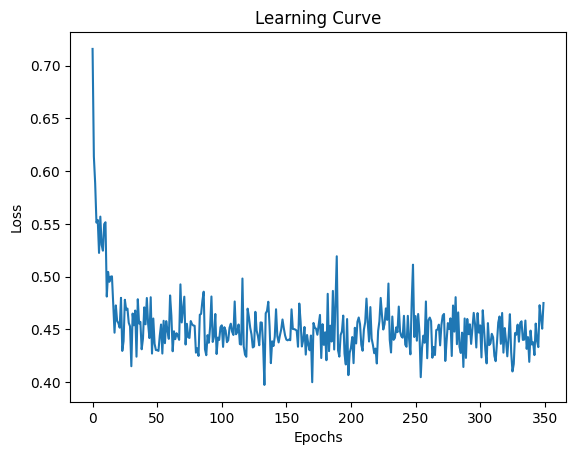

In [145]:
plt.plot(learning.history['loss'])
#plt.plot(learning.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.show()

Text(0, 0.5, 'Accuracy')

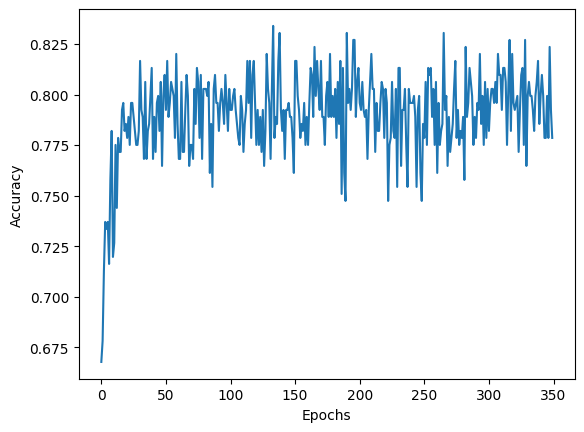

In [146]:
plt.plot(learning.history['binary_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [147]:
#confusion matrix
#Training and testing
p=model.predict(x_test)

4/4 [==============================] - 0s 5ms/step


In [148]:
p[p>=0.5]=1
p[p<0.5]=0

In [149]:
from sklearn.metrics import confusion_matrix
m=confusion_matrix(y_test,p)

In [150]:
m

array([[50, 16],
       [18, 41]], dtype=int64)

In [151]:
#PPV
ppv=(m[0][0])/(m[0][0]+m[1][0])
specificity=(m[1][1])/(m[1][1]+m[0][1])


In [152]:
ppv,specificity

(0.7352941176470589, 0.7192982456140351)

<Axes: >

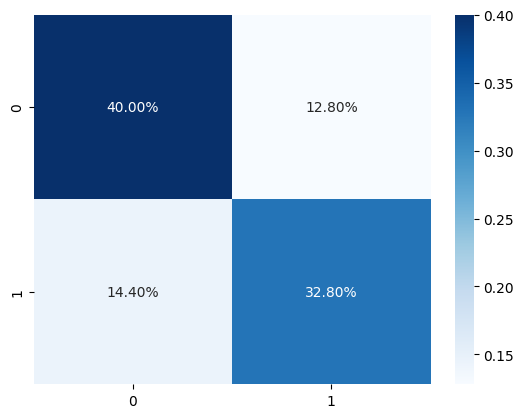

In [154]:
import seaborn as sn 
sn.heatmap(m/np.sum(m),annot=True,fmt='0.2%',cmap='Blues')
